This is a simple example on how you can use a jupyter notebook to train your model :) 

In [1]:
import torch
import torch.nn as nn
from task2 import Trainer, compute_loss_and_accuracy, create_plots

import dataloaders
#reload(dataloaders)

In [2]:
def compute_output_pooling(w1, h1, d1, f, s):
    w2 = (w1 - f) / s + 1
    h2 = (h1 - f) / s + 1
    d2 = d1
    return w2, h2, d2

def compute_output_convolution(w1, h1, d1, fw, fh, pw, ph, sw, sh, num_filter):
    w2 = (w1 - fw + 2*pw) / sw + 1
    h2 = (h1 - fh + 2*ph) / sh + 1
    d2 = num_filter
    return w2, h2, d2

num_filters = 16
w1, h1, d1 = 32, 32, 3
fw, fh, pw, ph, sw, sh = 3,3,1,1,1,1
f, s = 2, 2
for i in range(5):
    w1, h1, d1 = compute_output_convolution(w1, h1, d1, fw, fh, pw, ph, sw, sh, num_filters)
    num_filters *= 2
    w1, h1, d1 = compute_output_pooling(w1, h1, d1, f, s)
print(w1, h1, d1)

1.0 1.0 256


In [12]:
class ExampleModel(nn.Module):

    def __init__(self,
                 image_channels,
                 num_classes):
        """
            Is called when model is initialized.
            Args:
                image_channels. Number of color channels in image (3)
                num_classes: Number of classes we want to predict (10)
        """
        super().__init__()
        fw, fh, pw, ph, sw, sh = 3,3,1,1,1,1
        f, s = 2, 2
        num_filters = 64  # Set number of filters in first conv layer
        self.num_classes = num_classes
        # Define the convolutional layers
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(
                in_channels=image_channels,
                out_channels=num_filters,
                kernel_size=fw,
                stride=sw,
                padding=pw
            ),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=num_filters,
                out_channels=2*num_filters,
                kernel_size=fw,
                stride=sw,
                padding=pw
            ),
            nn.BatchNorm2d(2*num_filters),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.1),
            nn.Conv2d(
                in_channels=2*num_filters,
                out_channels=2*2*num_filters,
                kernel_size=fw,
                stride=sw,
                padding=pw
            ),
            nn.BatchNorm2d(2*2*num_filters),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=2*2*num_filters,
                out_channels=2*2*2*num_filters,
                kernel_size=fw,
                stride=sw,
                padding=pw
            ),
            nn.BatchNorm2d(2*2*2*num_filters),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.1),
            nn.Conv2d(
                in_channels=2*2*2*num_filters,
                out_channels=2*2*2*2*num_filters,
                kernel_size=fw,
                stride=sw,
                padding=pw
            ),
            nn.BatchNorm2d(2*2*2*2*num_filters),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=2*2*2*2*num_filters,
                out_channels=2*2*2*2*2*num_filters,
                kernel_size=fw,
                stride=sw,
                padding=pw
            ),
            nn.BatchNorm2d(2*2*2*2*2*num_filters),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.1),
        )
        # The output of feature_extractor will be [batch_size, num_filters, 16, 16]
        w1, h1, d1 = 32, 32, 3
        for i in range(6):
            w1, h1, d1 = compute_output_convolution(w1, h1, d1, fw, fh, pw, ph, sw, sh, num_filters)
            num_filters *= 2
            w1, h1, d1 = compute_output_pooling(w1, h1, d1, f, s)
        self.num_output_features = 32768 #int(w1 * h1 * d1)
        # Initialize our last fully connected layer
        # Inputs all extracted features from the convolutional layers
        # Outputs num_classes predictions, 1 for each class.
        # There is no need for softmax activation function, as this is
        # included with nn.CrossEntropyLoss
        self.classifier = nn.Sequential(
            nn.Linear(self.num_output_features, 64),
            nn.Softplus(),
            nn.Linear(64, num_classes),
        )

    def forward(self, x):
        """
        Performs a forward pass through the model
        Args:
            x: Input image, shape: [batch_size, 3, 32, 32]
        """
        batch_size = x.shape[0]
        out = self.feature_extractor(x)
        out = out.view(batch_size, -1)
        out = self.classifier(out)        
        expected_shape = (batch_size, self.num_classes)
        assert out.shape == (batch_size, self.num_classes),\
            f"Expected output of forward pass to be: {expected_shape}, but got: {out.shape}"
        return out

In [13]:
epochs = 10
batch_size = 64
learning_rate = 5e-2
early_stop_count = 4
dataloader = dataloaders.load_cifar10(batch_size)
model = ExampleModel(image_channels=3, num_classes=10)
trainer = Trainer(
    batch_size,
    learning_rate,
    early_stop_count,
    epochs,
    model,
    dataloader
)
trainer.train()

Files already downloaded and verified
Files already downloaded and verified
ExampleModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.1)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2,

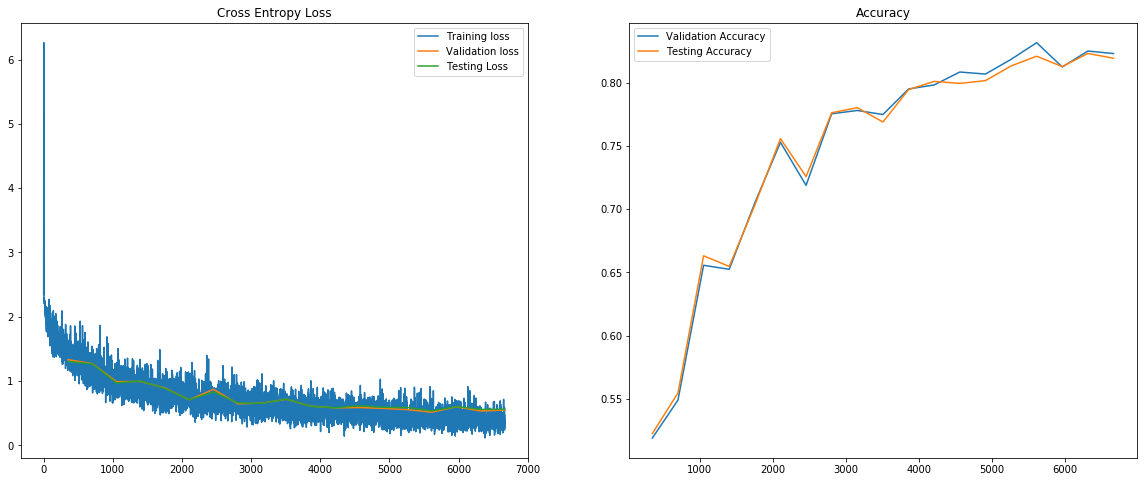

In [14]:
create_plots(trainer, "task3_bestmodel")